This notebook is inspired by the following blog: https://blog.collegefootballdata.com/talking-tech-bu/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

# Read in Data

#### Game Details

In [3]:
reg_season = pd.read_csv('../data/MRegularSeasonDetailedResults.csv')
reg_season.shape

(113241, 34)

#### Team Names

In [4]:
teams = pd.read_csv('../data/MTeams.csv',
                    usecols=['TeamID','TeamName'])
teams.shape

(378, 2)

#### Conferences

In [5]:
conf = pd.read_csv('../data/MTeamConferences.csv')

# Create Game Id

In [6]:
reg_season['GameID'] = reg_season.index

# Most Recent Season

In [7]:
recent = reg_season[reg_season['Season'] == 2024].reset_index(drop=True)
recent.shape

(5607, 35)

# Restructure Data into Home/Away Matchups

This data is structured based on the Winner vs Loser, and all of their stats, however I want it to be Away vs Home instead.

In [8]:
recent[recent['WLoc'] != 'N']['WLoc'].value_counts(normalize=True)

WLoc
H    0.649899
A    0.350101
Name: proportion, dtype: float64

# Only Consider Home/Away For Now

For now let's not worry about neutral court games. I need to think more about how to restructure this into away/home matchups.

In [9]:
matchups = recent[recent['WLoc'] != 'N'][['GameID','WTeamID','LTeamID','WLoc']].copy()

# Away team
matchups.loc[matchups['WLoc'] == 'A', 'ATeamID'] = matchups['WTeamID']
matchups.loc[matchups['WLoc'] == 'H', 'ATeamID'] = matchups['LTeamID']

# Home team
matchups.loc[matchups['WLoc'] == 'A', 'HTeamID'] = matchups['LTeamID']
matchups.loc[matchups['WLoc'] == 'H', 'HTeamID'] = matchups['WTeamID']

matchups[['ATeamID','HTeamID']] = matchups[['ATeamID','HTeamID']].astype(int)
matchups = matchups.drop(['WTeamID','LTeamID','WLoc'], axis=1)
matchups.shape

(4970, 3)

#### Get Stats Formatted

In [10]:
# column names
wcols = [c for c in recent.columns if c[0] == 'W']
lcols = [c for c in recent.columns if c[0] == 'L']

# separate winners/losers
winners = recent[['GameID']+wcols]
losers = recent[['GameID']+lcols]

# rename columns
winners.columns = ['GameID']+[c[1:] for c in wcols]
losers.columns = ['GameID']+[c[1:] for c in lcols]

# combine into 1 outcome dataframe
outcomes = pd.concat([winners, losers])\
             .drop('Loc', axis=1)
outcomes.shape

(11214, 16)

#### Bring Stats into Away/Home Matchup Dataframe

In [11]:
# Away stats
matchups = pd.merge(matchups, outcomes, left_on=['GameID','ATeamID'], right_on=['GameID','TeamID'], how='left')
matchups = matchups.drop(['TeamID'], axis=1)

# Away columns names
away_cols = ['GameID','ATeamID','HTeamID']+['A{}'.format(c) for c in matchups.columns if c not in ['GameID','ATeamID','HTeamID']]
matchups.columns = away_cols

matchups.shape

(4970, 17)

In [12]:
# Away stats
matchups = pd.merge(matchups, outcomes, left_on=['GameID','HTeamID'], right_on=['GameID','TeamID'], how='left')
matchups = matchups.drop(['TeamID'], axis=1)

# Away columns names
home_cols = away_cols+['H{}'.format(c) for c in matchups.columns if c not in away_cols]
matchups.columns = home_cols

matchups.shape

(4970, 31)

# Winning Margin

In [13]:
# assuming 3 point home court advantage
matchups['HMargin'] = matchups['HScore'] - matchups['AScore'] - 3
matchups['AMargin'] = -1*matchups['HMargin']

# Stacked Outcomes

In [14]:
away_outcomes = matchups[['GameID','ATeamID','HTeamID','AMargin']].rename(columns={'ATeamID':'Team', 'HTeamID':'Opponent', 'AMargin':'Margin'})
home_outcomes = matchups[['GameID','HTeamID','ATeamID','HMargin']].rename(columns={'HTeamID':'Team', 'ATeamID':'Opponent', 'HMargin':'Margin'})
outcomes = pd.concat([away_outcomes, home_outcomes], axis=0)
print(away_outcomes.shape, home_outcomes.shape, outcomes.shape)

(4970, 4) (4970, 4) (9940, 4)


# Average Margins by Team

In [15]:
margins = outcomes.groupby('Team').Margin.mean()

# SRS

In [16]:
# create empty arrays
terms = []
solutions = []

for team in margins.keys():
    row = []
    # get a list of team opponents
    opps = list(outcomes[outcomes['Team'] == team]['Opponent'])

    for opp in margins.keys():
        if opp == team:
        	# coefficient for the team should be 1
            row.append(1)
        elif opp in opps:
        	# coefficient for opponents should be 1 over the number of opponents
            row.append(-1.0/len(opps))
        else:
        	# teams not faced get a coefficient of 0
            row.append(0)

    terms.append(row)

    # average game spread on the other side of the equation
    solutions.append(margins[team])

In [17]:
solutions = np.linalg.solve(np.array(terms), np.array(solutions))
len(solutions)

362

In [18]:
ratings = list(zip(margins.keys(), solutions))
srs = pd.DataFrame(ratings, columns=['TeamID', 'srs'])
srs['Season'] = 2024
srs = pd.merge(teams, srs, on='TeamID', how='inner')
srs = pd.merge(srs, conf, on=['Season','TeamID'], how='inner')
srs.shape

(362, 5)

# Summarize SRS

In [19]:
srs[['srs']].describe().T

,count,mean,std,min,25%,50%,75%,max
srs,362.0,0.354637,7.342624,-20.926078,-4.302664,-0.12029,5.338115,21.767271


In [20]:
conf_srs = srs.groupby('ConfAbbrev')[['srs']].median().reset_index()
conf_srs.columns = ['Conference','SRS']
conf_srs = conf_srs.sort_values('SRS', ascending=True)\
                   .reset_index(drop=True)
conf_srs.shape

(33, 2)

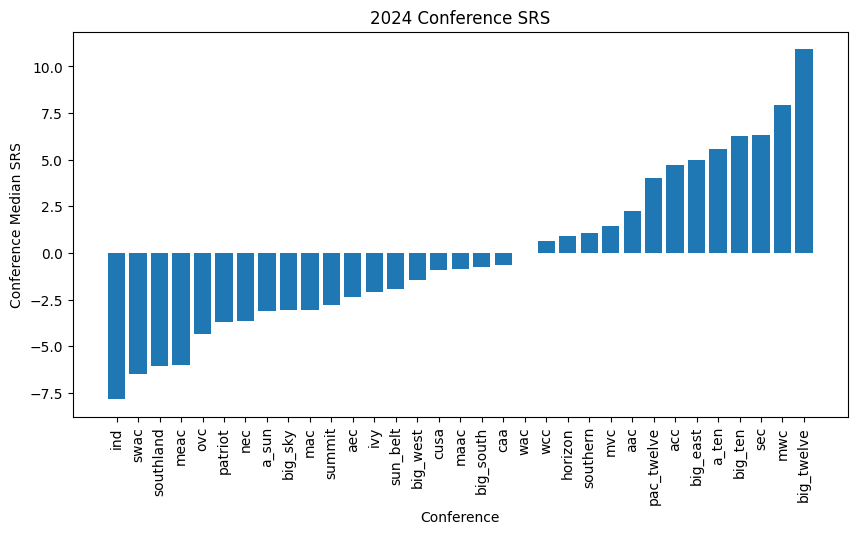

In [21]:
plt.figure(figsize=(10,5))
plt.bar(x=conf_srs['Conference'], height=conf_srs['SRS'])
plt.title('2024 Conference SRS')
plt.xlabel('Conference')
plt.ylabel('Conference Median SRS')
plt.xticks(rotation=90)
plt.show()

In [23]:
srs.sort_values('srs', ascending=False)\
   .head(25)\
   .reset_index(drop=True)

,TeamID,TeamName,srs,Season,ConfAbbrev
0,1222,Houston,21.767271,2024,big_twelve
1,1112,Arizona,20.138181,2024,pac_twelve
2,1345,Purdue,18.077183,2024,big_ten
3,1397,Tennessee,17.557444,2024,sec
4,1388,St Mary's CA,17.351457,2024,wcc
5,1235,Iowa St,17.020916,2024,big_twelve
6,1211,Gonzaga,17.001786,2024,wcc
7,1120,Auburn,16.953237,2024,sec
8,1163,Connecticut,15.966067,2024,big_east
9,1104,Alabama,15.634907,2024,sec
